In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile
from skimage.color import lab2rgb
from dataset import ImageColorizationDataset
from training import train_model #, load_model
import json
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

## Simple Convolutional Autoencoder (CAE) for 112x112 Images

### Test 1

In [2]:
# Define the CAE architecture
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 3x64x64
        - output: 8x8x8

        1. Conv2d: 3 input channels, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x8x8
        - output: 3x64x64
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 3 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re

# Initialize the CAE
model = CAE()

# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load dataset
train_dataset = datasets.Flowers102(root='flowers', split='train', transform=transform, download=True)
test_dataset = datasets.Flowers102(root='flowers', split='test', transform=transform)

# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the CAE
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
torch.save(model.state_dict(), 'CAE_0.pth')

cpu


[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch [1/50], Loss: 0.0937
Epoch [6/50], Loss: 0.0659
Epoch [11/50], Loss: 0.0303
Epoch [16/50], Loss: 0.0216
Epoch [21/50], Loss: 0.0179
Epoch [26/50], Loss: 0.0154
Epoch [31/50], Loss: 0.0142
Epoch [36/50], Loss: 0.0125
Epoch [41/50], Loss: 0.0105
Epoch [46/50], Loss: 0.0088


In [8]:
# Define the CAE architecture
class CAE_I(nn.Module):
    def __init__(self):
        super(CAE_I, self).__init__()
        """
        encoder architecture explained:
        - input: 3x64x64
        - output: 8x8x8

        1. Conv2d: 3 input channels, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x8x8
        - output: 3x64x64
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 3 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re
 
 
# Initialize the CAE
model = CAE_I()
 
# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
 
# Load dataset
train_dataset = datasets.Flowers102(root='flowers', 
                                    split='train', 
                                    transform=transform, 
                                    download=True)
test_dataset = datasets.Flowers102(root='flowers', 
                                   split='test', 
                                   transform=transform)
# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=128)
 
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
 
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Train the CAE
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'CAE_I_1.pth')
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

cpu
Epoch [1/100], Loss: 0.0848
Epoch [6/100], Loss: 0.0716
Epoch [11/100], Loss: 0.0371
Epoch [16/100], Loss: 0.0207
Epoch [21/100], Loss: 0.0157
Epoch [26/100], Loss: 0.0145
Epoch [31/100], Loss: 0.0141
Epoch [36/100], Loss: 0.0124
Epoch [41/100], Loss: 0.0107
Epoch [46/100], Loss: 0.0096
Epoch [51/100], Loss: 0.0088
Epoch [56/100], Loss: 0.0089
Epoch [61/100], Loss: 0.0084
Epoch [66/100], Loss: 0.0074
Epoch [71/100], Loss: 0.0075
Epoch [76/100], Loss: 0.0072
Epoch [81/100], Loss: 0.0070
Epoch [86/100], Loss: 0.0067
Epoch [91/100], Loss: 0.0068
Epoch [96/100], Loss: 0.0070


<Figure size 1600x1200 with 0 Axes>

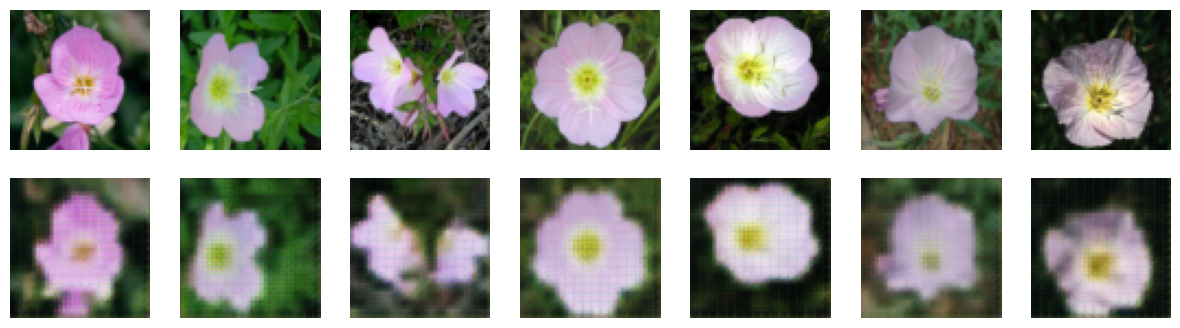

In [7]:
# load the model
model = CAE_I()
model.load_state_dict(torch.load('CAE_I_0.pth'))

with torch.no_grad():
    for data in test_loader:
        data, _ = data
        data = data.to(device)
        recon = model(data)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

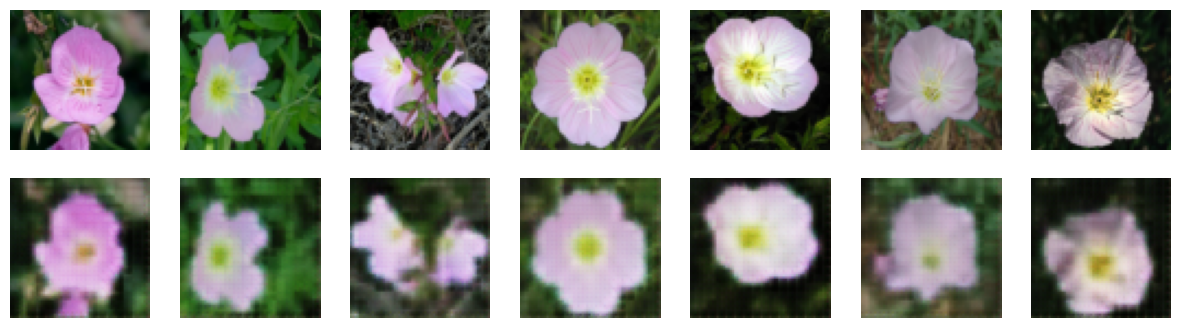

In [9]:
# load the model
model = CAE_I()
model.load_state_dict(torch.load('CAE_I_1.pth'))

with torch.no_grad():
    for data in test_loader:
        data, _ = data
        data = data.to(device)
        recon = model(data)
        break

plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [4]:
# Print size of original images, the encoded images and the decoded images
print(data[0].size())
print(recon[0].size())
print(output[0].size())

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


## With downloaded dataset

### Data Preparation

In [3]:
ab_path = Path("data/ab/ab")
l_path = Path("data/l")

### Data Loader

In [51]:
batch_size = 32
# Prepare the Datasets
all_dataset = ImageColorizationDataset(l_dir=l_path, ab_dir=ab_path, reduced=True)

# Definir las proporciones para entrenamiento, validación y prueba
train_ratio = 0.75
valid_ratio = 0.15
test_ratio = 0.1

# Calcular las longitudes de cada conjunto
total_count = len(all_dataset)
train_count = int(total_count * train_ratio)
valid_count = int(total_count * valid_ratio)
test_count = total_count - train_count - valid_count  # Asegura que sumen el total

# Establecer la semilla para reproducibilidad
torch.manual_seed(42)

# Dividir el dataset
train_dataset, valid_dataset, test_dataset = random_split(all_dataset, [train_count, valid_count, test_count])

# Crear DataLoader para cada conjunto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Imprimir las longitudes de los conjuntos
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de validación:", len(valid_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Tamaño del conjunto de entrenamiento: 2250
Tamaño del conjunto de validación: 450
Tamaño del conjunto de prueba: 300


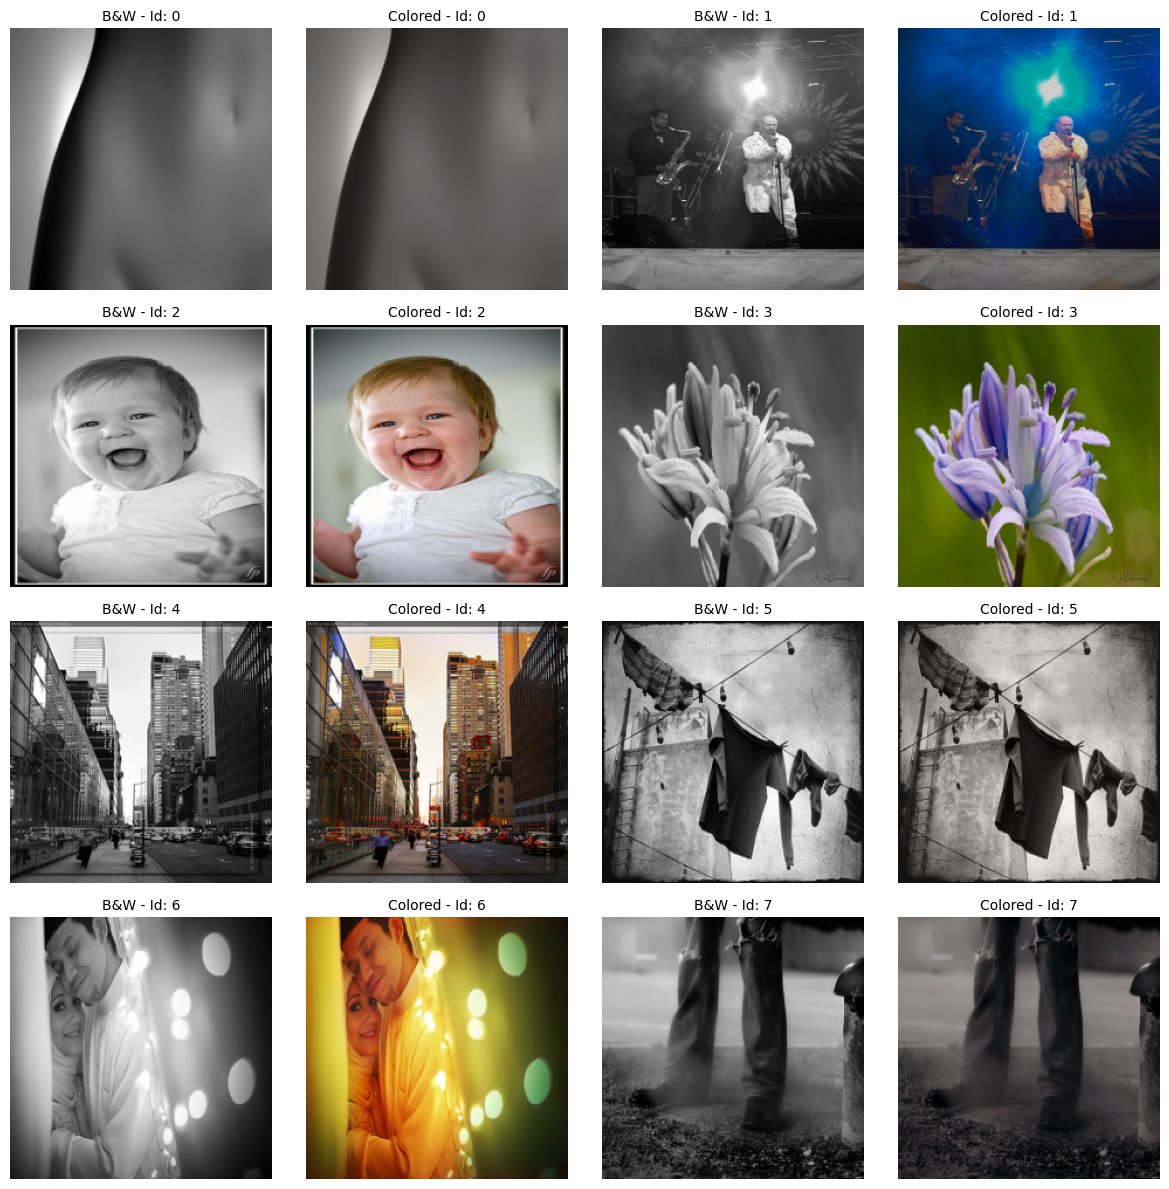

In [28]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

dataiter = iter(train_loader)
images, labels = next(dataiter)  # Carga un batch del DataLoader

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(labels[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

In [48]:
# Define the CAE architecture to colorize images (greyscale to LAB)

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        """
        encoder architecture explained:
        - input: 1x224x224
        - output: 8x28x28

        1. Conv2d: 1 input channel, 16 output channels, kernel size 3, stride 1, padding 1
        2. ReLU activation function
        3. MaxPool2d: kernel size 2, stride 2
        4. Conv2d: 16 input channels, 8 output channels, kernel size 3, stride 1, padding 1
        5. ReLU activation function
        6. MaxPool2d: kernel size 2, stride 2
        """
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        """
        decoder architecture explained:
        - input: 8x28x28
        - output: 2x224x224
        1. ConvTranspose2d: 8 input channels, 16 output channels, kernel size 3, stride 2, padding 1, output padding 1
        2. ReLU activation function
        3. ConvTranspose2d: 16 input channels, 2 output channels, kernel size 3, stride 2, padding 1, output padding 1
        4. Sigmoid activation function
        """
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        z = self.encoder(x)
        x_re = self.decoder(z)
        return x_re

In [49]:
architecture = CAE()
summary(architecture, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 224, 224]             160
              ReLU-2         [32, 16, 224, 224]               0
         MaxPool2d-3         [32, 16, 112, 112]               0
            Conv2d-4          [32, 8, 112, 112]           1,160
              ReLU-5          [32, 8, 112, 112]               0
         MaxPool2d-6            [32, 8, 56, 56]               0
   ConvTranspose2d-7         [32, 16, 112, 112]           1,168
              ReLU-8         [32, 16, 112, 112]               0
   ConvTranspose2d-9          [32, 2, 224, 224]             290
          Sigmoid-10          [32, 2, 224, 224]               0
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 643.12
Params size (MB): 0.01
Estimated Tot

In [39]:
architecture = CAE()
file_name = "cae_1.0"
train_model(train_loader, architecture, file_name, epochs=20)

Number of parameters: 2633
Epoch 1


Epoch 1: 100%|██████████| 71/71 [00:33<00:00,  2.13it/s, loss=0.0041]


Epoch 2


Epoch 2: 100%|██████████| 71/71 [00:33<00:00,  2.14it/s, loss=0.0030]


Epoch 3


Epoch 3: 100%|██████████| 71/71 [00:32<00:00,  2.15it/s, loss=0.0039]


Epoch 4


Epoch 4: 100%|██████████| 71/71 [00:35<00:00,  1.98it/s, loss=0.0032]


Epoch 5


Epoch 5: 100%|██████████| 71/71 [00:37<00:00,  1.89it/s, loss=0.0032]


Epoch 6


Epoch 6: 100%|██████████| 71/71 [00:37<00:00,  1.90it/s, loss=0.0037]


Epoch 7


Epoch 7: 100%|██████████| 71/71 [00:35<00:00,  2.01it/s, loss=0.0068]


Epoch 8


Epoch 8: 100%|██████████| 71/71 [00:42<00:00,  1.69it/s, loss=0.0021]


Epoch 9


Epoch 9: 100%|██████████| 71/71 [00:35<00:00,  2.01it/s, loss=0.0032]


Epoch 10


Epoch 10: 100%|██████████| 71/71 [00:36<00:00,  1.92it/s, loss=0.0037]


Epoch 11


Epoch 11: 100%|██████████| 71/71 [00:39<00:00,  1.80it/s, loss=0.0032]


Epoch 12


Epoch 12: 100%|██████████| 71/71 [00:34<00:00,  2.08it/s, loss=0.0020]


Epoch 13


Epoch 13: 100%|██████████| 71/71 [00:34<00:00,  2.07it/s, loss=0.0028]


Epoch 14


Epoch 14: 100%|██████████| 71/71 [00:36<00:00,  1.97it/s, loss=0.0019]


Epoch 15


Epoch 15: 100%|██████████| 71/71 [00:37<00:00,  1.89it/s, loss=0.0036]


Epoch 16


Epoch 16: 100%|██████████| 71/71 [00:49<00:00,  1.44it/s, loss=0.0062]


Epoch 17


Epoch 17: 100%|██████████| 71/71 [00:56<00:00,  1.25it/s, loss=0.0036]


Epoch 18


Epoch 18: 100%|██████████| 71/71 [00:36<00:00,  1.96it/s, loss=0.0086]


Epoch 19


Epoch 19: 100%|██████████| 71/71 [00:36<00:00,  1.97it/s, loss=0.0055]


Epoch 20


Epoch 20: 100%|██████████| 71/71 [00:34<00:00,  2.08it/s, loss=0.0021]


Finished Training


In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
architecture = architecture.to(device)
checkpoint = torch.load('cae_1.0_0.001_full.pt')
architecture.load_state_dict(checkpoint['model_state_dict'])
architecture.eval()

RuntimeError: Error(s) in loading state_dict for CAE:
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([16, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 2, 3, 3]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

In [44]:
# load model from: cae_1.0_0.001_full.pt
architecture = CAE()
architecture.load_state_dict(torch.load("cae_1.0_0.001_full.pt"))


RuntimeError: Error(s) in loading state_dict for CAE:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.3.weight", "encoder.3.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "time", "running_losses". 

In [42]:
# Evaluate results
architecture = CAE()
file_name = "cae_1.0"
architecture.load_state_dict(torch.load(f"{file_name}.pth"))
architecture.eval()

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the output
output = architecture(images)

# Configuración del plot
fig, axs = plt.subplots(4, 4, figsize=(12, 12))  # 4 filas, 4 columnas para 8 pares de imágenes

for i in range(8):  # Solo necesitamos 8 pares de imágenes, total 16 subplots
    row = i // 2  # Cada fila tiene 2 pares
    col = (i % 2) * 2  # Columna alterna para B&W y Colored (0, 2 para B&W; 1, 3 para Colored)

    l_image = tensor_to_numpy(images[i]).squeeze()  # [H, W], quita el canal si es 1
    ab_image = tensor_to_numpy(output[i])  # [2, H, W]

    # Asegurarse de que los datos están en la escala correcta
    l_image = l_image * 100  # Escalar L de [0, 1] a [0, 100]
    ab_image = (ab_image - 0.5) * 255  # Escalar a y b de [-0.5, 0.5] a [-128, 127]

    # Imagen en escala de grises
    axs[row, col].imshow(l_image, cmap='gray')
    axs[row, col].set_title(f'B&W - Id: {i}', fontsize=10)
    axs[row, col].axis('off')  # Desactiva los ejes

    # Imagen coloreada
    img_lab = np.zeros((224, 224, 3), dtype=np.float32)
    img_lab[:,:,0] = l_image  # L canal
    img_lab[:,:,1:] = ab_image.transpose(1, 2, 0)  # a y b canales
    img_rgb = lab2rgb(img_lab)  # Convierte LAB a RGB
    axs[row, col + 1].imshow(img_rgb)
    axs[row, col + 1].set_title(f'Colored - Id: {i}', fontsize=10)
    axs[row, col + 1].axis('off')

RuntimeError: Error(s) in loading state_dict for CAE:
	Missing key(s) in state_dict: "encoder.0.weight", "encoder.0.bias", "encoder.3.weight", "encoder.3.bias", "decoder.0.weight", "decoder.0.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "time", "running_losses". 